In [1]:
import os
import cv2
import datetime as dt
import json
import itertools

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import utm

import utils

In [2]:
geojson_path = "data/target_zone.geojson"
dates = (dt.date(2020, 7, 27), dt.date(2020, 8, 8))
cloud_cover_percentage = (0, 30)
credentials_path = "secrets/sentinel_api_credentials.json"
shape = geojson_to_wkt(read_geojson(geojson_path))

In [3]:
with open(credentials_path, 'r') as infile:
    credentials = json.load(infile)

api = SentinelAPI(
    credentials["username"],
    credentials["password"]
)

images = api.query(
    area=shape,
    date=dates,
    platformname="Sentinel-2",
    processinglevel="Level-2A",
    cloudcoverpercentage=cloud_cover_percentage
)

images_df = api.to_dataframe(images)

In [ ]:
uuid = "4172581f-67cf-4c08-9250-be29c86bfae7"
# uuid = "a6889608-c2b4-4b0d-a731-a7f0c2da8951"
# api.download("0f30f930-88c3-4540-b478-414df01ef414")
print(utils.minimize_dataframe(images_df))

Dans la cellule suivante, on a :
* la première valeur correspond au 27 juillet 2020 (avant l'incendie)
* la deuxième date du 29 juillet mais l'image n'est pas exploitable (quasiment que du noir)
* la troisième correspond au 6 août 2020 donc après l'incendie

In [4]:
# article file
# image_folder = "./data/S2B_MSIL2A_20200727T105619_N0214_R094_T30TXQ_20200727T144035.SAFE"
# image_folder = "./data/S2A_MSIL2A_20200729T105031_N0214_R051_T30TXQ_20200729T134025.SAFE"
image_folder = "./data/S2B_MSIL2A_20200806T105619_N0214_R094_T30TXQ_20200806T131026.SAFE"

In [ ]:
band_dict = {
    band: utils.get_band(image_folder, band, resolution=10)
    for band in ["B02", "B03", "B04", "B08"] # NDVI + RGB
    # for band in ["B12", "B8A", "B04"] # SWIR
}

In [ ]:
# TODO

# Shapefile en sortie -> fiona

Save image before the fire

In [ ]:
band4 = utils.get_band(image_folder, "B04", resolution=10)
band4 = utils.open_rasterio(band4)

In [ ]:
image_path = '/'.join(
    ['./data', 'S2B_MSIL2A_20200727T105619_N0214_R094_T30TXQ_20200727T144035.SAFE', 'GRANULE',
    'L2A_T30TXQ_A017709_20200727T110643', 'IMG_DATA', 'R10m/']
)
print(image_path)

band4 = rasterio.open(image_path + 'T30TXQ_20200727T105619_B04_10m.jp2', driver='JP2OpenJPEG') # red
band8 = rasterio.open(image_path + 'T30TXQ_20200727T105619_B08_10m.jp2', driver='JP2OpenJPEG') # nir

print(band4.count)
print(band4.width)
print(band4.height)

red = band4.read(1).astype('float64')
nir = band8.read(1).astype('float64')

ndvi_bef = np.where(
    (nir + red) == 0.,
    0.,
    (nir - red) / (nir + red)
)

In [ ]:
ndvi_img = rasterio.open('./output/ndvi_img_before.tiff', 'w', driver='GTiff',
    width=band4.width, height=band4.height, count=1,
    crs=band4.crs, transform=band4.transform,
    dtype='float64'
)

ndvi_img.write(ndvi_bef, 1)
ndvi_img.close()

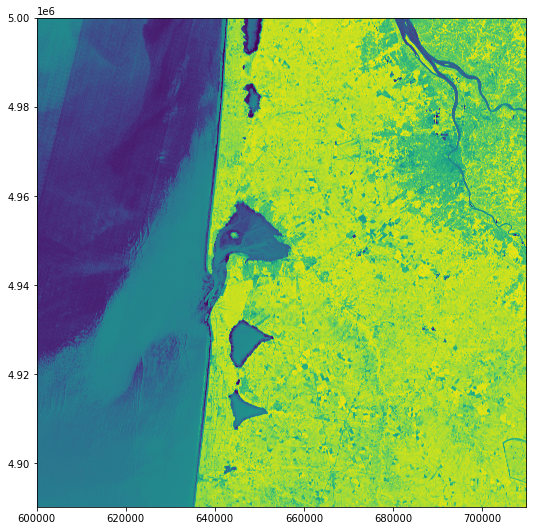

In [5]:
ndvi_bef = rasterio.open('./output/ndvi_img_before.tiff')

plt.figure(figsize=(16, 9))
plot.show(ndvi_bef)
plt.show()

Save the image from after the fire

In [ ]:
image_path = '/'.join(
    ['./data', 'S2B_MSIL2A_20200806T105619_N0214_R094_T30TXQ_20200806T131026.SAFE', 'GRANULE',
    'L2A_T30TXQ_A017852_20200806T105752', 'IMG_DATA', 'R10m/']
)
print(image_path)

band4 = rasterio.open(image_path + 'T30TXQ_20200806T105619_B04_10m.jp2', driver='JP2OpenJPEG')
band8 = rasterio.open(image_path + 'T30TXQ_20200806T105619_B08_10m.jp2', driver='JP2OpenJPEG')

plt.figure(figsize=(12, 8))
plot.show(band4)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
plot.show(band4, ax=ax1)
plot.show(band8, ax=ax2)
fig.tight_layout()

In [ ]:
red = band4.read(1).astype('float64')
nir = band8.read(1).astype('float64')

ndvi_after = np.where(
    (nir + red) == 0.,
    0.,
    (nir - red) / (nir + red)
)

In [ ]:
ndvi_img = rasterio.open('./output/ndvi_img_after.tiff', 'w', driver='GTiff',
    width=band4.width, height=band4.height, count=1,
    crs=band4.crs, transform=band4.transform,
    dtype='float64'
)

ndvi_img.write(ndvi_after, 1)
ndvi_img.close()

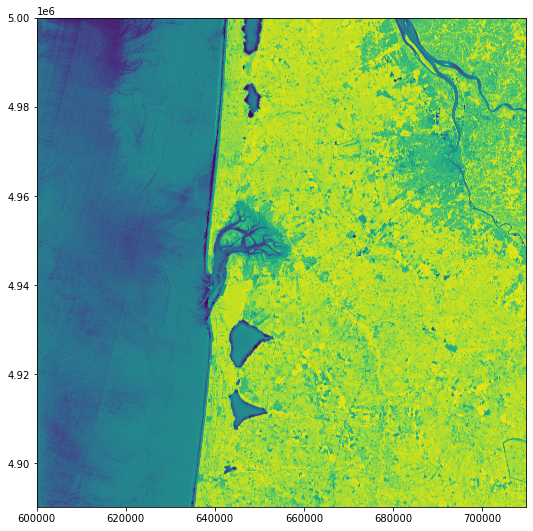

In [6]:
ndvi_after = rasterio.open('./output/ndvi_img_after.tiff')

plt.figure(figsize=(16, 9))
plot.show(ndvi_after)
plt.show()

(10980, 10980)


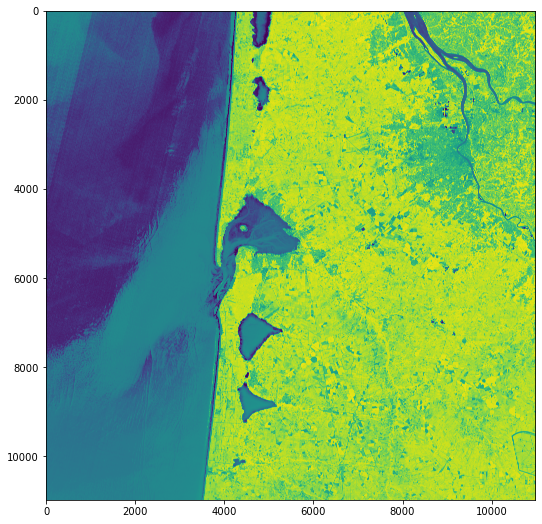

In [8]:
arr1 = ndvi_bef.read(1)
print(arr1.shape)

plt.figure(figsize=(16, 9))
plt.imshow(arr1)
plt.show()

In [ ]:
# Recreating an RGB image
img = cv2.merge((band_dict["B04"], band_dict["B03"], band_dict["B02"])) # RGB
# img = cv2.merge((band_dict["B08"], band_dict["B04"], band_dict["B03"])) # Infrared
# img = cv2.merge((band_dict["B12"], band_dict["B8A"], band_dict["B04"])) # SWIR

plt.imshow(img)
plt.show()

In [ ]:
img_processed = img / 8
img_processed = img_processed.astype(int)

plt.imshow(img_processed)
plt.show()

Par tâtonnements j'ai trouvé la zone de l'incendie

Splitting the images to machine learning ready sizes

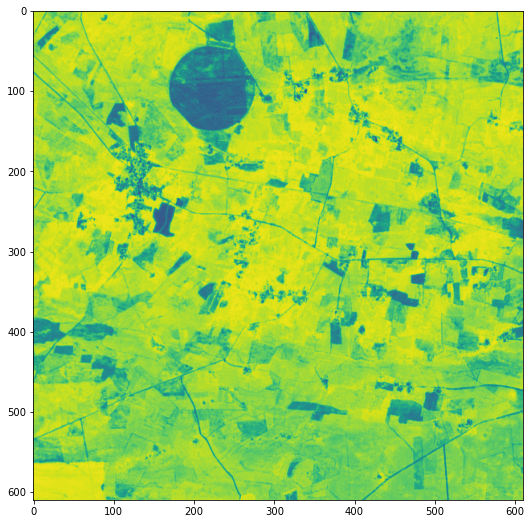

In [9]:
frag_count = 18
frag_size = int(arr1.shape[0] / frag_count)
frag_dict = {}

for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = arr1[y * frag_size: (y + 1) * frag_size,
        x * frag_size: (x + 1) * frag_size]

plt.figure(figsize=(16, 9))
plt.imshow(frag_dict[(15, 12)])
plt.show()

(10980, 10980)


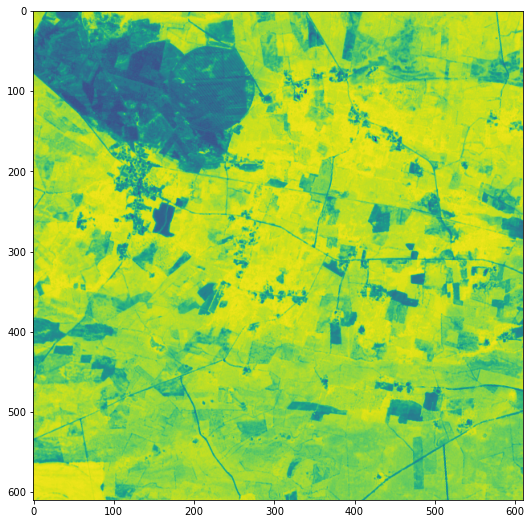

In [10]:
arr2 = ndvi_after.read(1)
print(arr2.shape)

frag_dict = {}

for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = arr2[y * frag_size: (y + 1) * frag_size,
        x * frag_size: (x + 1) * frag_size]

plt.figure(figsize=(16, 9))
plt.imshow(frag_dict[(15, 12)])
plt.show()

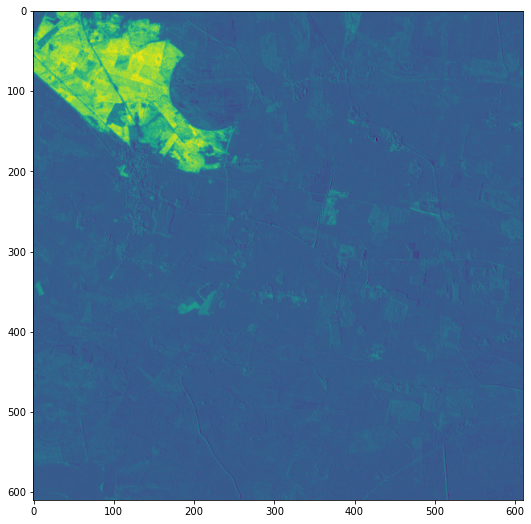

In [11]:
diff = arr1 - arr2 # before - after
frag_dict = {}

for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = diff[y * frag_size: (y + 1) * frag_size,
        x * frag_size: (x + 1) * frag_size]

plt.figure(figsize=(16, 9))
plt.imshow(frag_dict[(15, 12)])
plt.show()

Seuillage (arbitraire pour le moment) des petites valeurs

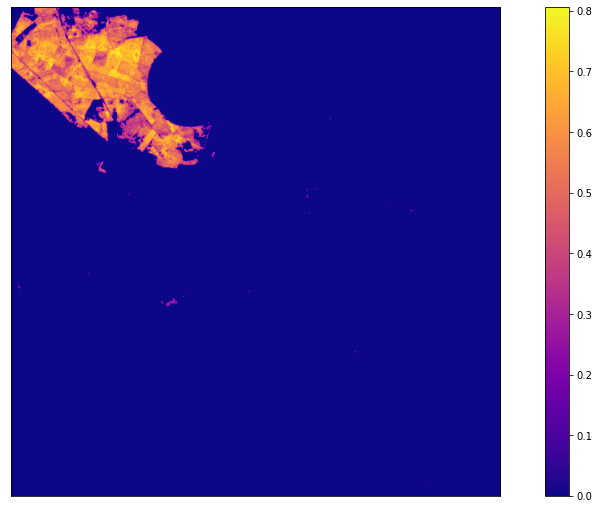

In [12]:
seuil = 0.25
wf = frag_dict[(15, 12)]
wf = utils.threshold_filter(wf, seuil)

plt.figure(figsize=(16, 9))
plt.imshow(wf, cmap="plasma")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

Calcul préliminaire de l'aire brûlée

In [13]:
area = utils.calculate_area(wf, arr1)
print(f'Aire de la zone brûlée en km^2 : {area} km^2')
# to hectares
print(f'Aire de la zone brûlée en hectares : {round(area * 100, 2)} ha')

Aire de la zone brûlée en km^2 : 2.3928 km^2
Aire de la zone brûlée en hectares : 239.28 ha


In [15]:
res = utils.merge_four_images([
    frag_dict[(14, 11)],
    frag_dict[(15, 11)],
    frag_dict[(14, 12)],
    frag_dict[(15, 12)]
])

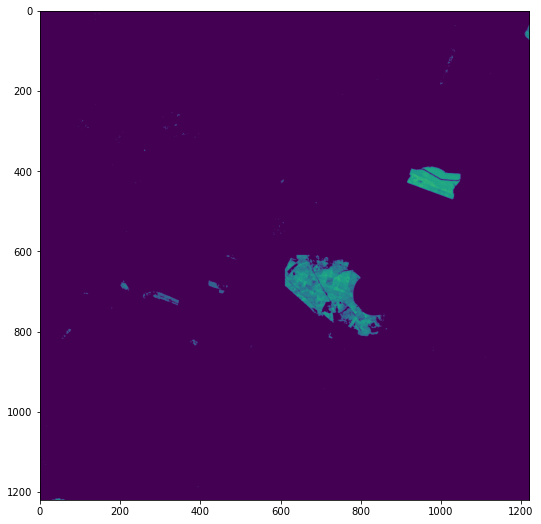

In [21]:
res = utils.threshold_filter(res, 0.3)

plt.figure(figsize=(16, 9))
plt.imshow(res)
plt.show()

In [25]:
utils.calculate_area(res, arr1) * 100

315.69000000000005

In [ ]:
def get_tci_file_path(image_folder):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R10m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == "TCI"][0]
    
    return f"{image_folder_path}/{selected_file}"

tci_file_path = get_tci_file_path(image_folder)

In [ ]:
# Testing with the center of fragment 15, 12
pixel_column = int(frag_size * 15.5)
pixel_row = int(frag_size * 12.5)
print(f"pixel_column: {pixel_column}")
print(f"pixel_row: {pixel_row}")

UTM: Universal Tranverse Mercator

In [ ]:
transform = rasterio.open(tci_file_path, driver='JP2OpenJPEG').transform
zone_number = int(tci_file_path.split("/")[-1][1:3])
zone_letter = tci_file_path.split("/")[-1][0]

utm_x, utm_y = transform[2], transform[5]

In [ ]:
utm_x, utm_y

In [ ]:
# Converting pixel position to UTM
east = utm_x + pixel_column * 10
north = utm_y + pixel_row * - 10

# Converting UTM to latitude and longitude
latitude, longitude = utm.to_latlon(east, north, zone_number, zone_letter)

In [ ]:
print(f"latitude, longitude: {latitude}, {longitude} ")

In [ ]:
# Converting latitude and longitude to UTM
east, north, zone_number, zone_letter = utm.from_latlon(latitude, longitude, force_zone_number=zone_number)

# Converting UTM to column and row
pixel_column = round((east - utm_x) / 10)
pixel_row = round((north - utm_y) / - 10)

In [ ]:
print(f"pixel_column: {pixel_column}")
print(f"pixel_row: {pixel_row}")

In [ ]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.imshow(frag_dict[(14, 11)])
plt.subplot(222)
plt.imshow(frag_dict[(15, 11)])
plt.subplot(223)
plt.imshow(frag_dict[(14, 12)])
plt.subplot(224)
plt.imshow(frag_dict[(15, 12)])
# plt.savefig("test2.png")
plt.show()

In [ ]:
img1 = frag_dict[(14, 11)]
img2 = frag_dict[(15, 11)]
img3 = frag_dict[(14, 12)]
img4 = frag_dict[(15, 12)]

merged = utils.merge_four_images([img1, img2, img3, img4])
plt.imshow(merged)
plt.show()

Edge detection with Canny

In [ ]:
img = cv2.imread("output/test2.png")
edges = cv2.Canny(img, 100, 200)

plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()